<a href="https://colab.research.google.com/github/jaspergass/Tomato-Object-Detection/blob/Wallace-Branch-V2/Tomato_Object_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tomato Detection Project

Have you ever purchased Tomatoes in bulk? Struggled to pick out the rotten or unripe ones while doing prep for your restaurant or large gathering? Look no further than NAME!

This supervised detection model uses YOLOv8 and object-bounding boxes to analyze photos of groups of tomatoes, easily identifying any outliers.

Clone the git repo into the files of colab so that we can access the paths for our dataset.

In [19]:
!git clone https://github.com/jaspergass/Tomato-Object-Detection.git

Cloning into 'Tomato-Object-Detection'...
remote: Enumerating objects: 1240, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1240 (delta 3), reused 2 (delta 2), pack-reused 1235 (from 1)
Receiving objects: 100% (1240/1240), 149.58 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (98/98), done.


Import necessary libraries

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

Here, we keep track of the path for where our training, validate, and test folders are located.

In [21]:
#set the paths to labels and images directory
label_dir= "/content/Tomato-Object-Detection/Final_data/labels"
image_dir= "/content/Tomato-Object-Detection/Final_data/images"

Visualizing some sample pictures from the dataset



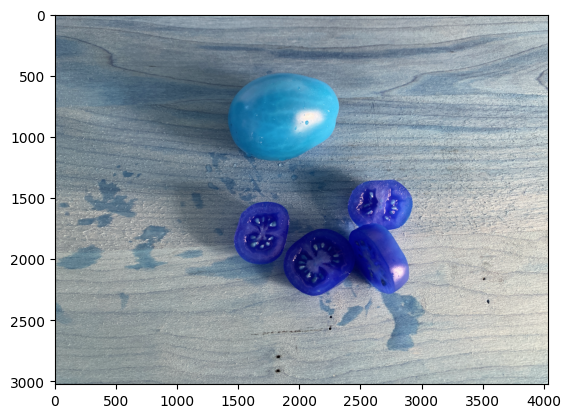

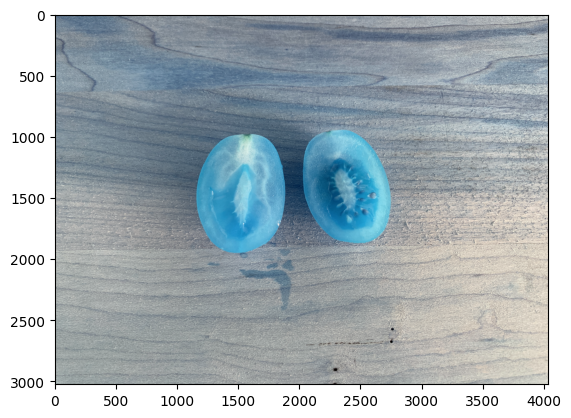

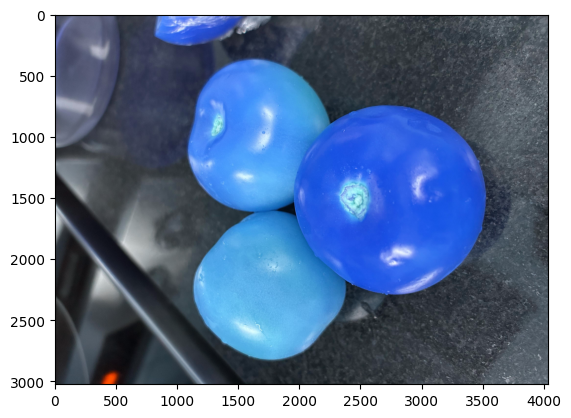

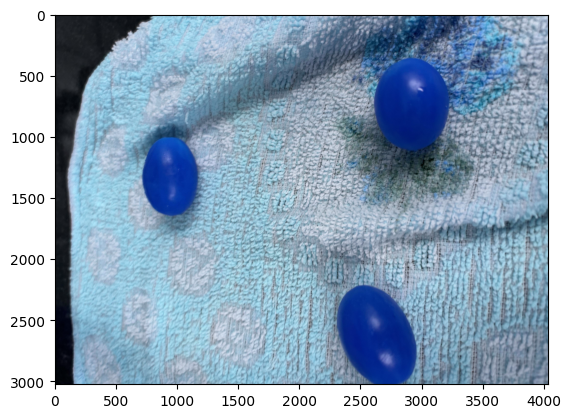

In [22]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "val2"))):
    img = cv2.imread(os.path.join(image_dir,"val2", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

Creating Dataframes from .xml files, from which we will eventually create .txt file for each image

In [23]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Streaming output truncated to the last 5000 lines.
<Element 'x14' at 0x7d3b5b3d6520>
<Element 'y14' at 0x7d3b5b3d5b20>
<Element 'x15' at 0x7d3b5b3d5cb0>
<Element 'y15' at 0x7d3b5b3d6480>
<Element 'x16' at 0x7d3b5b3d64d0>
<Element 'y16' at 0x7d3b5b3d7d80>
<Element 'x17' at 0x7d3b5b3d4130>
<Element 'y17' at 0x7d3b5b3d70b0>
<Element 'x18' at 0x7d3b5b3d4400>
<Element 'y18' at 0x7d3b5b3d43b0>
<Element 'object' at 0x7d3b5b3d4e50>
<Element 'name' at 0x7d3b5b3d7e20>
<Element 'pose' at 0x7d3b5b3d5800>
<Element 'truncated' at 0x7d3b5b3d5850>
<Element 'difficult' at 0x7d3b5b3d5760>
<Element 'occluded' at 0x7d3b5b3d5620>
<Element 'bndbox' at 0x7d3b5b3d4f90>
<Element 'xmin' at 0x7d3b5b3d5710>
<Element 'xmax' at 0x7d3b5b3d53a0>
<Element 'ymin' at 0x7d3b5b3d4b80>
<Element 'ymax' at 0x7d3b5b3d5670>
<Element 'polygon' at 0x7d3b5b3d4c20>
<Element 'x1' at 0x7d3b5b3d4d60>
<Element 'y1' at 0x7d3b5b3d4db0>
<Element 'x2' at 0x7d3b5b3d4e00>
<Element 'y2' at 0x7d3b5b3d4cc0>
<Element 'x3' at 0x7d3b5b3d6fc0>
<El

In [24]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

Doing the same with val2

In [25]:
#import glob
#import xml.etree.ElementTree as ET

df3 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/val2" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df3['label'] += [label]
                    df3['width'] += [width]
                    df3['height'] += [height]
                    df3['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df3['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df3['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df3['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df3['ymax'] += [ymax]

/content/Tomato-Object-Detection/Final_data/labels/val2/IMG_4164.xml
<Element 'annotation' at 0x7d3b5f8330b0>
<Element 'folder' at 0x7d3b5f832d90>
<Element 'filename' at 0x7d3b5f8335b0>
<Element 'path' at 0x7d3b5f833fb0>
<Element 'source' at 0x7d3b5f8321b0>
<Element 'database' at 0x7d3b5f831f80>
<Element 'size' at 0x7d3b5f832c50>
<Element 'width' at 0x7d3b5f8336a0>
<Element 'height' at 0x7d3b5f833a10>
<Element 'depth' at 0x7d3b5f832a70>
<Element 'object' at 0x7d3b5f833330>
<Element 'name' at 0x7d3b5f833150>
<Element 'pose' at 0x7d3b5f831df0>
<Element 'truncated' at 0x7d3b5f832250>
<Element 'difficult' at 0x7d3b5f830680>
<Element 'bndbox' at 0x7d3b5f833b00>
<Element 'xmin' at 0x7d3b5f831f30>
<Element 'ymin' at 0x7d3b5f8332e0>
<Element 'xmax' at 0x7d3b5f833790>
<Element 'ymax' at 0x7d3b5f831ad0>
<Element 'object' at 0x7d3b5f832ac0>
<Element 'name' at 0x7d3b5f831b20>
<Element 'pose' at 0x7d3b5f833650>
<Element 'truncated' at 0x7d3b5f832750>
<Element 'difficult' at 0x7d3b5f830ef0>
<Element

In [26]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
val2_df=pd.DataFrame(df3)
#df1.head()

# val_df.head()
val2_df

,name,label,width,height,xmin,ymin,xmax,ymax
0,IMG_4164,healthy-tomato,4032,3024,1146,969,1895,1955
1,IMG_4164,healthy-tomato,4032,3024,2022,936,2732,1867
2,IMG_4173,healthy-tomato,4032,3024,2302,176,3244,975
3,IMG_4173,healthy-tomato,4032,3024,2143,1250,2798,1730
4,IMG_4173,healthy-tomato,4032,3024,2286,1873,2958,2594
...,...,...,...,...,...,...,...,...
201,IMG_4161,healthy-tomato,4032,3024,2104,1807,2694,2506
202,IMG_4161,healthy-tomato,4032,3024,2671,1454,3349,2137
203,IMG_4205,healthy-tomato,4032,3024,1069,1102,1636,1812
204,IMG_4205,healthy-tomato,4032,3024,1669,1548,2677,2743


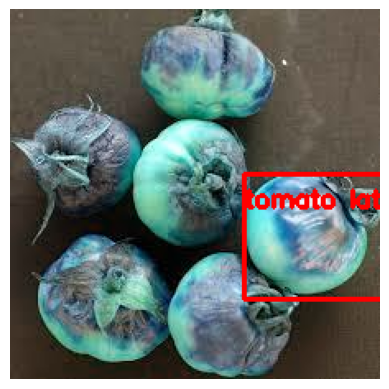

In [27]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Visualizing some images from our data

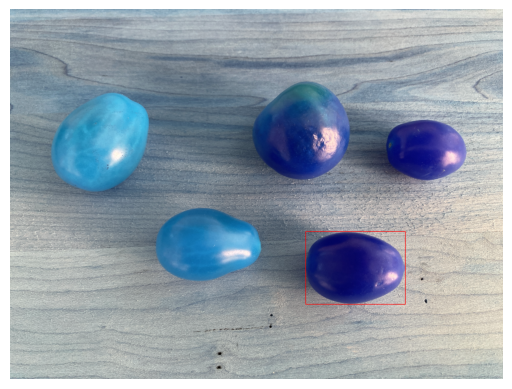

In [33]:
index= 100 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"val2", val2_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (val2_df['xmin'][index], val2_df['ymin'][index]), (val2_df['xmax'][index], val2_df['ymax'][index]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+1], val2_df['ymin'][index+1]), (val2_df['xmax'][index+1], val2_df['ymax'][index+1]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+2], val2_df['ymin'][index+2]), (val2_df['xmax'][index+2], val2_df['ymax'][index+2]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+3], val2_df['ymin'][index+3]), (val2_df['xmax'][index+3], val2_df['ymax'][index+3]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+4], val2_df['ymin'][index+4]), (val2_df['xmax'][index+4], val2_df['ymax'][index+4]), (255, 0, 0), 3)
# Put label (class_id) near the bbox
label = val2_df["label"][index]
# cv2.putText(image, str(label), (val2_df['xmin'][index], val2_df['ymin'][index]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# label2 = val2_df["label"][index+1]
# cv2.putText(image, str(label2), (val2_df['xmin'][index+1], val2_df['ymin'][index+1]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# label3 = val2_df["label"][index+2]
# cv2.putText(image, str(label3), (val2_df['xmin'][index+2], val2_df['ymin'][index+2]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# label4 = val2_df["label"][index+3]
# cv2.putText(image, str(label4), (val2_df['xmin'][index+3], val2_df['ymin'][index+3]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# label5 = val2_df["label"][index+4]
# cv2.putText(image, str(label5), (val2_df['xmin'][index+4], val2_df['ymin'][index+4]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

                                                name                label  \
0  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
1  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
2  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
3  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
4  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
5  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
6  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   
7  download-23-_jpg.rf.21c17f9054e07f134d99630555...  tomato early blight   

   width  height  xmin  ymin  xmax  ymax  
0    259     194    39    66    94   120  
1    259     194    57    14   108    64  
2    259     194   113    12   166    64  
3    259     194   107    74   157   123  
4    259     194    68   123   126   181  
5    259     194   138   125   200   185  
6    

Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    147 non-null    object
 1   label   147 non-null    object
 2   width   147 non-null    int64 
 3   height  147 non-null    int64 
 4   xmin    147 non-null    int64 
 5   ymin    147 non-null    int64 
 6   xmax    147 non-null    int64 
 7   ymax    147 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 9.3+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [ ]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['tomato early blight' 'tomato late blight' 'healthy-tomato'
 'tomato bacterial spot']
['tomato early blight' 'tomato bacterial spot' 'healthy-tomato'
 'tomato late blight']
[]


We need to map labels to class_ids required for YOLO

In [ ]:
label_map = {'tomato early blight': 0,
            'tomato late blight': 1,
            'healthy-tomato': 2,
            'tomato bacterial spot': 3}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,39,66,94,120,0
1,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,57,14,108,64,0
2,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,113,12,166,64,0
3,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,107,74,157,123,0
4,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,68,123,126,181,0


convertig the bounding box format to the one required by YOLO:

In [ ]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,39,66,94,120,0,0.256757,0.479381,0.212355,0.278351
1,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,57,14,108,64,0,0.318533,0.201031,0.196911,0.257732
2,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,113,12,166,64,0,0.538610,0.195876,0.204633,0.268041
3,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,107,74,157,123,0,0.509653,0.507732,0.193050,0.252577
4,download-23-_jpg.rf.21c17f9054e07f134d99630555...,tomato early blight,259,194,68,123,126,181,0,0.374517,0.783505,0.223938,0.298969


Deleting all the sample with Nan values in training and validation data

In [ ]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (937, 13)
after deleting(train_data):  (937, 13)
before deleting (val data):  (147, 13)
after deleting(val data):  (147, 13)


converting the dataframe to type str (string) to be stored in text files.

In [ ]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [ ]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
100,images-31-_jpg.rf.ffb0c93f0be9ad1f7466696f55e2...,tomato late blight,263,192,30,32,167,161,1,0.3745247148288973,0.5026041666666666,0.5209125475285171,0.671875


In [ ]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

Checking the folders if every image file has a corresponding label file

(We will copy the code, we already used in previous turorial after updating)

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

43   =   41


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): {'img_p2_65_jpeg'}
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): {'images-5-_jpg', 'images-6-_jpg'}
Validation Extra labels (without corresponding images): set()


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SFU_Archive/IAT360/Computer Vision Project/Datasets/Tomato.v1i.voc/Final_data/images/train/img_p2_65_jpeg.jpg'